### Loading and Preprocessing

In [3]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, make_scorer, classification_report, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, average_precision_score

grades = pd.read_csv('../lm/data/data_with_scaled_grades.csv')

grades.dropna(subset=['scaled_grade'], inplace=True) # get rid of any rows with NAs in essay or scaled_grade
grades['scaled_grade'].isna().sum()

grade_proportions = grades['scaled_grade'].value_counts(normalize=True).sort_index() # percentage for each grade

grade_proportions = grade_proportions.reindex(['A', 'B', 'C', 'D', 'F']).fillna(0).tolist()

print(grade_proportions)

grade_encoded, grade_labels = pd.factorize(grades['scaled_grade'])

[0.14148108191415582, 0.3574015566001387, 0.34121907991061107, 0.13970871541958851, 0.020189566155505895]


### Train Test Split

In [4]:
grades_encoded, grade_labels = grades['scaled_grade'].factorize(sort=True)

In [5]:
train, test = train_test_split(grades_encoded)

### Calculating Class Probability

In [6]:
train_props = pd.Series(train).value_counts(normalize=True).sort_index().iloc[::-1]

### Prediction

In [7]:
preds = np.random.choice([0,1,2,3,4],len(test),p=train_props.values)

### Evaluation

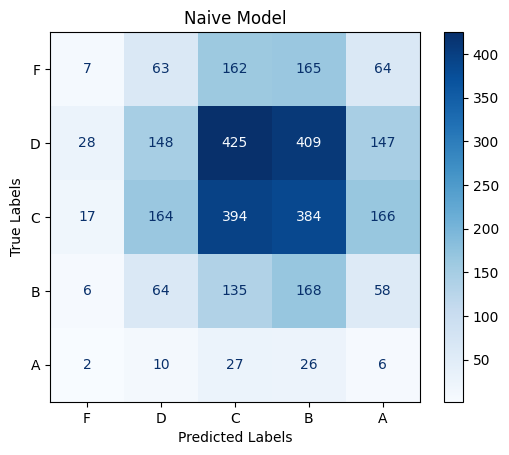

In [8]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test,preds)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=["F", "D", "C", "B", "A"])

fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax) 

ax.set_title('Naive Model')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

In [9]:
print(classification_report(test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.12      0.02      0.03       461
           1       0.33      0.13      0.18      1157
           2       0.34      0.35      0.35      1125
           3       0.15      0.39      0.21       431
           4       0.01      0.08      0.02        71

    accuracy                           0.22      3245
   macro avg       0.19      0.19      0.16      3245
weighted avg       0.27      0.22      0.22      3245



### Function to Calculate QWK

In [10]:
def quadratic_weighted_kappa(conf_matrix):

    w = np.zeros_like(conf_matrix, dtype=float)

    num_categories = conf_matrix.shape[0] 

    for i in range(num_categories):
        for j in range(num_categories):
            w[i, j] = ((i - j) / (num_categories - 1)) ** 2


    total_observations = conf_matrix.sum()

    row_totals = conf_matrix.sum(axis=1)

    col_totals = conf_matrix.sum(axis=0)

    e = np.zeros_like(conf_matrix, dtype=float)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            e[i, j] = (row_totals[i] * col_totals[j]) / total_observations


    num = 0
    den = 0
    for i in range(num_categories):
        for j in range(num_categories):
            num += (w[i,j] * conf_matrix[i,j])
            den += (w[i,j] * e[i,j])

    return 1 - (num/den)


quadratic_weighted_kappa(conf_matrix)

0.0011299565394504718

### Monte Carlo Simulation for Mean QWK

In [15]:
qwks = []
for _ in range(1000):
    train, test = train_test_split(grades_encoded)
    train_props = pd.Series(train).value_counts(normalize=True).sort_index()
    preds = np.random.choice(train_props.keys(),len(test),p=train_props.values)
    conf_matrix = confusion_matrix(test,preds)
    qwks.append(quadratic_weighted_kappa(conf_matrix))


print(np.mean(qwks))

-0.001195029446652728


qwk is very close to 0, thats what we can expect because this metric tells us how much better than random our classifier is and our classifier is random.